# Study on the high contrast star

## Test synthesis

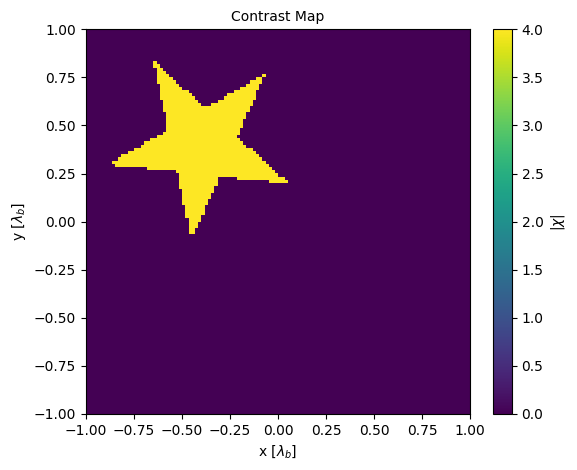

KeyboardInterrupt: 

In [43]:
import sys
sys.path.insert(1, '../../../eispy2d/library/')

import configuration as cfg
import inputdata as ipt
import result as rst
import draw
import mom_cg_fft as mom

# Parameters
name = 'star4'
file_path = "../../../data/position/single/"
NM = NS = 80
Ro = 4.
lambda_b = 1.
epsilon_rb = 1.
Lx = Ly = 2.
E0 = 1.
perfect_dielectric = True
resolution = (120, 120)
noise = 5.
indicators = [rst.SHAPE_ERROR, rst.POSITION_ERROR, rst.OBJECTIVE_FUNCTION]
epsilon_rd = 5. # 6.00
l = 0.5
position = [.4, -.4]
rotate = 30

config = cfg.Configuration(name=name + '.cfg', number_measurements=NM, 
                           number_sources=NS, observation_radius=Ro, 
                           wavelength=lambda_b,
                           background_permittivity=epsilon_rb,
                           image_size=[Ly, Lx], magnitude=E0,
                           perfect_dielectric=perfect_dielectric)


test = ipt.InputData(name=name + '.ipt', configuration=config, 
                     resolution=resolution, noise=noise, indicators=indicators)

chi = (epsilon_rd-epsilon_rb)/epsilon_rb

test.rel_permittivity, _ = draw.star5(
    l, axis_length_x=Lx, axis_length_y=Ly, resolution=resolution,
    background_rel_permittivity=epsilon_rb, object_rel_permittivity=epsilon_rd,
    center=position, rotate=30.
)

test.draw(show=True)

forward = mom.MoM_CG_FFT(tolerance=1e-3, maximum_iterations=10000,
                         parallelization=True)

_ = forward.solve(test, PRINT_INFO=True)

test.save(file_path=file_path)

## Reconstruction by Born Approximation

Method: First-Order Born Approximation
Alias: ba
Input Data: star4.ipt
Discretization: Richmond Method (40x40)
Parallelization: False
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e+01


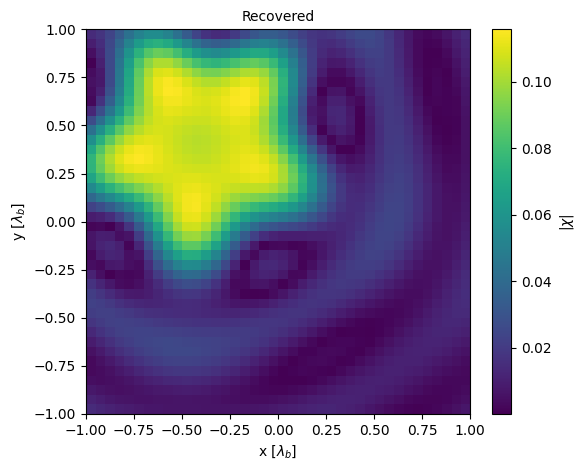

In [ ]:
import bornapprox as ba
import regularization as reg
import richmond as ric

test.indicators.remove(rst.OBJECTIVE_FUNCTION)
resolution = (40, 40)
discretization = ric.Richmond(configuration=config,
                              elements=resolution)
regularization = reg.Tikhonov(reg.TIK_FIXED, parameter=1e1)
method = ba.FirstOrderBornApproximation(regularization)
result = method.solve(test, discretization)
result.plot_map(show=True)

* Surprisingly, the geometry reconstruction is good.
* The higher the regularization parameter, the better the smoothness tends to be. At the same time, the contrast value is lower.

## Reconstruction by Subspace Optimization Method

Method: Subspace-based Optimization Method
Alias: som
Input Data: star4.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=5000, tolerance=1.0e-03)
Stop Criteria
Maximum number of iterations: 150
Iteration: 1 -  Shape: 75.02, Position: 3.97, Ob. Func.: 4.199e+02,
Iteration: 2 -  Shape: 72.35, Position: 2.85, Ob. Func.: 4.089e+02,
Iteration: 3 -  Shape: 92.90, Position: 4.91, Ob. Func.: 2.163e+02,
Iteration: 4 -  Shape: 95.49, Position: 14.37, Ob. Func.: 1.395e+02,
Iteration: 5 -  Shape: 120.13, Position: 4.28, Ob. Func.: 1.014e+02,
Iteration: 6 -  Shape: 132.83, Position: 8.46, Ob. Func.: 5.269e+01,
Iteration: 7 -  Shape: 148.45, Position: 9.51, Ob. Func.: 2.938e+01,
Iteration: 8 -  Shape: 150.79, Position: 7.41, Ob. Func.: 2.271e+01,
Iteration: 9 -  Shape: 153.30, Position: 6.19, Ob. Func.: 2.019e+01,
Iteration: 10 -  Shape: 159.73, Position: 4.53, Ob. Func.: 1.872e+01,
Iteration: 20 -  Shape: 189.81, Position: 2.03, Ob. Func.: 1.550e+01,
Iteration: 30 

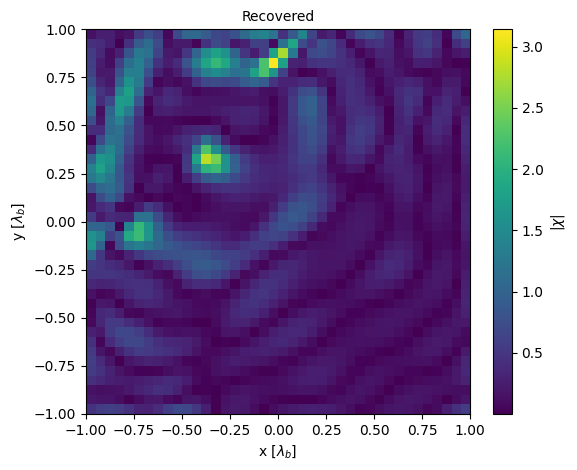

In [ ]:
import som
import stopcriteria as stp

test.indicators.append(rst.OBJECTIVE_FUNCTION)

method = som.SubspaceBasedOptimizationMethod(
    stp.StopCriteria(max_iterations=150), cutoff_index=15
)

result = method.solve(test, discretization, print_info=True,
                      initial_guess=result.rel_permittivity)

result.plot_map(show=True)

* Even when providing the BA solution as the initial solution for SOM, this doesn't make the method converge.
* That is, even when the initial geometry is good, the fact that the contrast is very low leads the method to not converge correctly.

And this can happen even with Backpropagation, which is the standard initialization method for SOM, and with many iterations (1000):

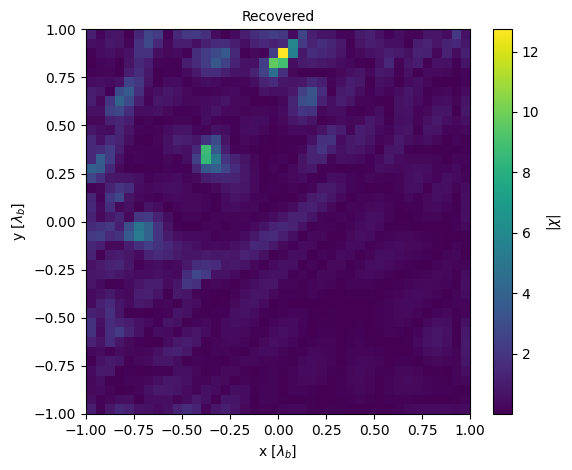

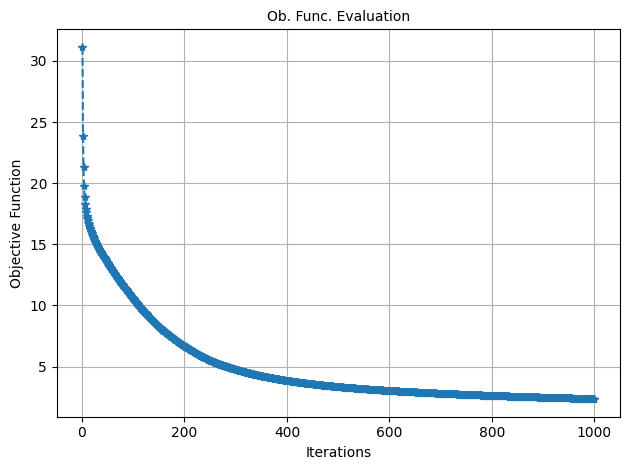

In [46]:
result = rst.Result(import_filename='star4_som.rst',
                    import_filepath=file_path)
result.plot_map(show=True)
_ = result.plot_convergence(indicators=rst.OBJECTIVE_FUNCTION, show=True)

## Reconstruction by Born Iterative Method

My guess was that BIM could perform better if the Tikhonov parameter changes during the iterations, but it didn't work. The method still converges to a non-sense solution:

Method: Born Iterative Method
Alias: bim
Input Data: star4.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=10000, tolerance=1.0e-03)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e+00
Stop Criteria
Maximum number of iterations: 5
Iteration: 1 -  Shape: 153.80, Position: 11.82, Ob. Func.: 8.147e+02,
Iteration: 2 -  Shape: 146.37, Position: 1.64, Ob. Func.: 1.708e+02,
Iteration: 3 -  Shape: 202.34, Position: 0.68, Ob. Func.: 7.951e+01,
Iteration: 4 -  Shape: 230.16, Position: 0.47, Ob. Func.: 5.127e+01,
Iteration: 5 -  Shape: 237.59, Position: 0.47, Ob. Func.: 4.717e+01,
Method: Born Iterative Method
Alias: bim
Input Data: star4.ipt
Discretization: Richmond Method (40x40)
Method of Moments - CG-FFT (iterations=10000, tolerance=1.0e-03)
Regularization Method: Tikhonov
Choice strategy: fixed
Parameter value: 1.000e-01
Stop Criteria
Maximum number of iterations: 5
Iteration: 1 -  Shape: 196.91, Position: 8.51, Ob. Func.: 9.54

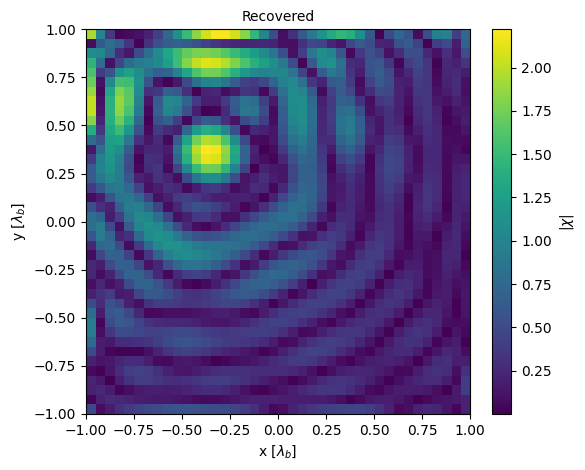

In [ ]:
import bim
test.indicators.remove(rst.OBJECTIVE_FUNCTION)
regularization = reg.Tikhonov(reg.TIK_FIXED, parameter=1e1)
method = ba.FirstOrderBornApproximation(regularization)
initial_guess = method.solve(test, discretization, print_info=False)
test.indicators.append(rst.OBJECTIVE_FUNCTION)

regularization =  reg.Tikhonov(reg.TIK_FIXED, parameter=1e0)
method = bim.BornIterativeMethod(forward, regularization,
                                 stp.StopCriteria(max_iterations=5))
result = method.solve(test, discretization, print_info=True,
                      initial_guess=initial_guess.rel_permittivity)

regularization =  reg.Tikhonov(reg.TIK_FIXED, parameter=1e-1)
method = bim.BornIterativeMethod(forward, regularization,
                                 stp.StopCriteria(max_iterations=5))
result = method.solve(test, discretization, print_info=True,
                      initial_guess=result.rel_permittivity)

regularization =  reg.Tikhonov(reg.TIK_FIXED, parameter=1e-2)
method = bim.BornIterativeMethod(forward, regularization,
                                 stp.StopCriteria(max_iterations=5))
result = method.solve(test, discretization, print_info=True,
                      initial_guess=result.rel_permittivity)

result.plot_map(show=True)